In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from random_data_analysis import get_path_lengths_for_all_users
from data_parser import convert_data, get_csv

In [9]:
df = pd.read_csv('data/current_model_prefs.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,subject,preferred_model,evaluation,parameters
0,0e9aebe0-7972-11ed-9421-5535258a0716,Combined_Memory,-0.437731,"[0.0, 1.5, 0.75, 0.1, 10.0]"
1,14914210-7972-11ed-a3bb-674c56c9a5f7,Combined_Memory,-0.449267,"[0.0, 1.0, 0.5, 0.1, 10.0]"
2,1af65fa0-7972-11ed-8e76-65fbafc77b31,Steps_Cells,-0.475267,"[2.0, 10.0]"
3,1c5fb3a0-7972-11ed-92f5-192da827d727,Probability_Weighted,-0.459824,"[1.0, 1.25, 10.0]"
4,1ed4f960-7972-11ed-abfe-53a0662f3357,Random,-0.484267,"[0.0, 10.0]"


In [3]:
# get fraction of subjects who prefer each model
bar_chart_data = {}
for model in ['Combined_Memory', 'Combined_No_Memory', 'Steps_Cells', 'Discounted_Utility', 'Probability_Weighted', 'Expected_Utility', 'Random']:
    bar_chart_data[model] = df[df['preferred_model'] == model]['subject'].nunique()/df['subject'].nunique()

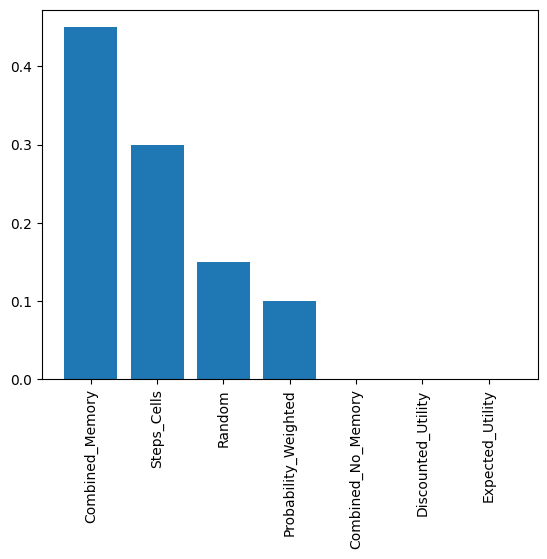

In [4]:
# plot bar chart in sorted order
sorted_keys = sorted(bar_chart_data, key=bar_chart_data.get, reverse=True)
sorted_values = [bar_chart_data[key] for key in sorted_keys]
plt.bar(sorted_keys, sorted_values)
plt.xticks(rotation='vertical')
plt.show()

In [5]:
# plot avg total path length for each user
decisions = convert_data(get_csv('data/prolific_data_filtered'))
path_lengths_by_user = get_path_lengths_for_all_users(decisions)
total_path_length_per_user = []
for tester_id in path_lengths_by_user:
    total_path_length_per_user.append(sum(path_lengths_by_user[tester_id]))

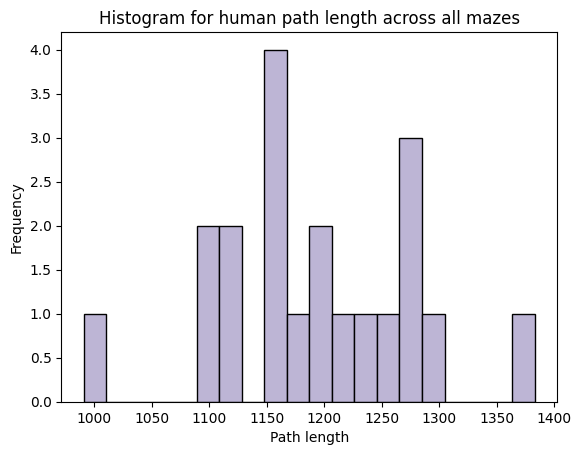

In [6]:
plt.hist(total_path_length_per_user, bins=20, histtype = 'bar', edgecolor='black', color='#BDB5D5')
plt.ylabel('Frequency')
plt.xlabel('Path length')
plt.title('Histogram for human path length across all mazes')
plt.show()